# Analysis of the 2018 Quarterbacks

This is an analysis of the 2018 season Quarterback performance, speficially using the QB Rating. 

![](https://usatftw.files.wordpress.com/2017/04/qbdraft1.gif?w=1000&h=600&crop=1)

In [1]:
# imports
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 200) # Display up to 120 columns of a dataframe

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
from matplotlib import style



Import data from the great [ryurko / nflscrapR-data](https://github.com/ryurko/nflscrapR-data) . Your the best!

In [2]:
nfl = pd.read_csv('reg_pbp_2018.csv')
nfl.head()

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (167,168,169,170,179,180,183,184,189,190,191,192,204,205,206,232,233,234,239,241,242) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,home_wp_post,away_wp_post,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,...,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,receiver_player_id,receiver_player_name,rusher_player_id,rusher_player_name,lateral_receiver_player_id,lateral_receiver_player_name,lateral_rusher_player_id,lateral_rusher_player_name,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tackle_2_player_id,assist_tackle_2_player_name,assist_tackle_2_team,assist_tackle_3_player_id,assist_tackle_3_player_name,assist_tackle_3_team,assist_tackle_4_player_id,assist_tackle_4_player_name,assist_tackle_4_team,pass_defense_1_player_id,pass_defense_1_player_name,pass_defense_2_player_id,pass_defense_2_player_name,fumbled_1_team,fumbled_1_player_id,fumbled_1_player_name,fumbled_2_player_id,fumbled_2_player_name,fumbled_2_team,fumble_recovery_1_team,fumble_recovery_1_yards,fumble_recovery_1_player_id,fumble_recovery_1_player_name,fumble_recovery_2_team,fumble_recovery_2_yards,fumble_recovery_2_player_id,fumble_recovery_2_player_name,return_team,return_yards,penalty_team,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
0,37,2018090600,PHI,ATL,ATL,away,PHI,PHI,35.0,2018-09-06,900.0,1800.0,3600.0,Half1,0,1,0,1,NaN,0.0,15:00,PHI 35,0,73,J.Elliott kicks 65 yards from PHI 35 to end zo...,kickoff,0,0,0,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

### Set indicator for Week #s


In [3]:
import datetime
def game_weeks(df):
    """
    Create dataset indicate the game week. 
    """
    
    week_dict = {}
    first_game_date = df.min().date()
    game_date = first_game_date
    season_start_date = pd.to_datetime('2018-09-04 00:00:00').date()
    last_game_date = df.max().date()
    week_num = 1 # start week 1 and increment from there
    
    for i in range((last_game_date - first_game_date).days+1):
        if game_date <= season_start_date:
            week_dict[game_date] = 0
            game_date += datetime.timedelta(days=1)
        else:
            if game_date.weekday() == 1: # check if weekday is Tuesday.. if so reset week_number
                week_num += 1
            week_dict[game_date] = week_num
            game_date += datetime.timedelta(days=1)
    
    week_list = pd.Series(week_dict).to_frame()[0]
    
    return week_list

d = game_weeks(pd.to_datetime(nfl.game_date))
for o,j in enumerate(d.index):
    nfl.loc[nfl.game_date == str(j), 'week'] = d[o]

## Player: Passing Stats

In [4]:
qb = nfl[(nfl.play_type=='pass')].groupby(['passer_player_name']).agg({
    'game_id':lambda x: x.nunique(), # unique counts for each game
    'complete_pass': sum,
    'pass_attempt':sum, 
    'yards_gained':sum,
    'touchdown':sum,
    'interception':sum,
    'first_down_pass':sum,
    'pass_attempt':sum,
    'sack':sum,
    #'success_play':sum,
    'week':'mean',
})


# net yards gained per pass attempts [PFR]
# yards gain includes detuctions on sack yards outcomes
qb['net_yrd_per_pass_att'] = qb.yards_gained / (qb.pass_attempt + qb.sack)

# completion %
qb['pct_cmp'] = round((qb.complete_pass / qb.pass_attempt), 1)    # receiving yards per reception 
qb['pct_td'] = round((qb.touchdown / qb.pass_attempt), 1)    # % of TDs when attempting a pass

#qb = qb[qb.pass_attempt >= 50]

## NFL Passer Rating Formula
The NFL passer rating formula includes four variables:
    - completions percentages
    - yards per attempt
    - touchdowns per attempt
    - interception per attempt

Each of these variables is scaled to a value between 0 and 2.375, with 
1.0 being statistically average (based on league data between 1960-1970).

Note: passing performance in 2017 as the league average rating was 88.6

Source: https://en.wikipedia.org/wiki/Passer_rating 

In [5]:
qb['cmp'] = ((qb.complete_pass / qb.pass_attempt) - .3) * 5           # completion percentage
qb['ypa'] = ((qb.yards_gained / qb.pass_attempt) - 3) * .25          # yards per attempt
qb['tdpa'] = (qb.touchdown / qb.pass_attempt) * 20                # touchdowns per attempt 
qb['intpa'] = 2.375 - ((qb.interception / qb.pass_attempt) * 25)     # interceptions per attempt 

def pass_rate_quality_check(rating):
    """
    If the result of any calculation is greater than 2.375, it is set to 2.375. 
    If the result is a negative number, it is set to zero.
    """
    if rating > 2.375:
        rating = 2.375

    elif rating < 0:
        rating = 0
    
    return rating


qb['cmp_q'] = qb.cmp.apply(lambda x: pass_rate_quality_check(x))
qb['ypa_q'] = qb.ypa.apply(lambda x: pass_rate_quality_check(x))
qb['tdpa_q'] = qb.tdpa.apply(lambda x: pass_rate_quality_check(x))
qb['intpa_q'] = qb.intpa.apply(lambda x: pass_rate_quality_check(x))

# Passer Rating

qb['pass_rate'] = ((qb['cmp_q'] + qb['ypa_q'] + qb['tdpa_q'] + qb['intpa_q']) / 6) * 100

qb.drop(['cmp_q','ypa_q','tdpa_q','intpa_q'], axis=1, inplace=True)

In [6]:
# Ranks
# minimum 50 passes

qb['qbr_rank'] = qb.groupby('passer_player_name')['pass_rate'].sum().rank(ascending=False)
qb.sort_values(['pass_rate','game_id'], ascending = [False, True], inplace = True)

In [69]:
qb_[qb_.passer_player_name == "D.Brees"]

,passer_player_name,game_id,complete_pass,pass_attempt,yards_gained,touchdown,interception,first_down_pass,sack,week,net_yrd_per_pass_att,pct_cmp,pct_td,cmp,ypa,tdpa,intpa,pass_rate,qbr_rank
85,D.Brees,15,364.0,507.0,3873,32.0,5.0,199.0,17.0,8.278107,7.391221,0.7,0.1,2.089744,1.159763,1.262327,2.128452,110.671433,17.0


----
As interm analysis, we will use the NFL Leadersboard from [stats.washintonpost.come](http://stats.washingtonpost.com/fb/leaders.asp?range=NFL&rank=039&type=Passing) until the play by play stats is ready.

In [8]:
qb_leaderboard = pd.read_table("./quarterback_rating.txt")
qb_leaderboard

,Rank,Name,Team,G,QB Rating,Att,Comp,Comp %,Pass Yds,Yd/A,Yd/G,TD,Int
0,1,D. Brees,NO,15,115.7,489,364,74.4,3992,8.16,266.1,32,5
1,2,P. Mahomes,KC,15,114.0,556,369,66.4,4816,8.66,321.1,48,11
2,3,R. Wilson,Sea,15,112.7,406,268,66.0,3296,8.12,219.7,34,6
3,4,M. Ryan,Atl,15,108.5,564,391,69.3,4546,8.06,303.1,33,6
4,5,P. Rivers,LAC,15,107.7,484,333,68.8,4132,8.54,275.5,31,10
5,6,D. Watson,Hou,15,104.1,470,320,68.1,3931,8.36,262.1,26,9
6,7,C. Wentz,Phi,11,102.2,401,279,69.6,3074,7.67,279.5,21,7
7,8,K. Cousins,Min,15,100.9,573,405,70.7,4166,7.27,277.7,29,10
8,9,R. Fitzpatrick,TB,8,100.4,246,164,66.7,2366,9.62,295.8,17,12
9,10,J. Goff,LAR,15,99.5,535,349,65.2,4489,8.39,299.3,28,12


Bar plot

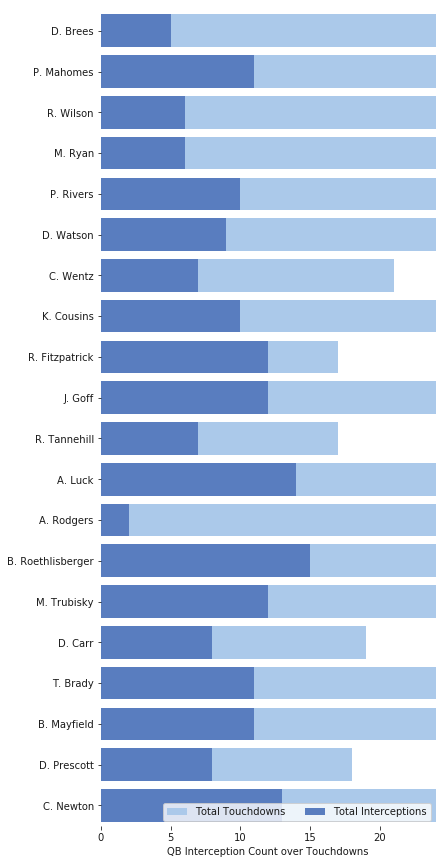

In [9]:
# https://seaborn.pydata.org/examples/horizontal_barplot.html

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="TD", y="Name", data=qb_leaderboard,
            label="Total Touchdowns", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="Int", y="Name", data=qb_leaderboard,
            label="Total Interceptions", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="QB Interception Count over Touchdowns")
sns.despine(left=True, bottom=True)

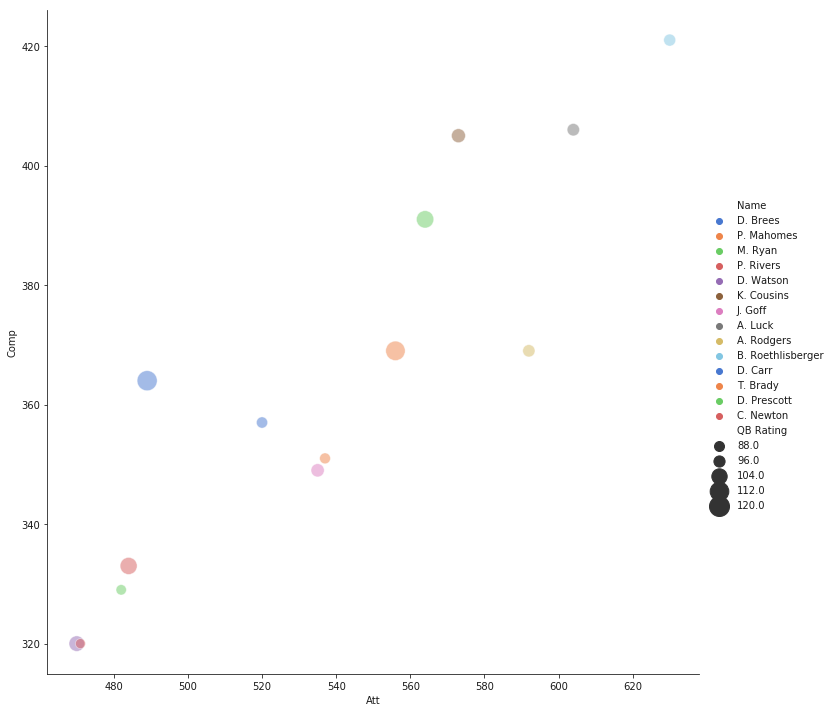

In [10]:
# Plot Passin Completions against Passing Attempts with other semantics
sns.relplot(x="Att", y="Comp", hue="Name", size="QB Rating",
            sizes=(100, 400), alpha=.5, palette="muted",
            height=10, data=qb_leaderboard[qb_leaderboard.Comp > 300])

In [11]:
qb_leaderboard[qb_leaderboard.Comp > 300]

,Rank,Name,Team,G,QB Rating,Att,Comp,Comp %,Pass Yds,Yd/A,Yd/G,TD,Int
0,1,D. Brees,NO,15,115.7,489,364,74.4,3992,8.16,266.1,32,5
1,2,P. Mahomes,KC,15,114.0,556,369,66.4,4816,8.66,321.1,48,11
3,4,M. Ryan,Atl,15,108.5,564,391,69.3,4546,8.06,303.1,33,6
4,5,P. Rivers,LAC,15,107.7,484,333,68.8,4132,8.54,275.5,31,10
5,6,D. Watson,Hou,15,104.1,470,320,68.1,3931,8.36,262.1,26,9
7,8,K. Cousins,Min,15,100.9,573,405,70.7,4166,7.27,277.7,29,10
9,10,J. Goff,LAR,15,99.5,535,349,65.2,4489,8.39,299.3,28,12
11,12,A. Luck,Ind,15,98.0,604,406,67.2,4308,7.13,287.2,36,14
12,13,A. Rodgers,GB,15,97.8,592,369,62.3,4416,7.46,294.4,25,2
13,14,B. Roethlisberger,Pit,15,97.3,630,421,66.8,4842,7.69,322.8,33,15
